# Particle spray algorithm by Chen et al. (2024)

Author: Yingtian "Bill" Chen

We provide a notebook to generate streams using the Chen+24 ([arXiv:2408.01496](https://arxiv.org/abs/2408.01496)) model via `agama`. This implementation is based on Eugene Vasiliev's tutorial notebook during the [Streams24](https://stellarstreams.org/streams24/) workshop at Durham.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import agama
agama.setUnits(length=1, velocity=1, mass=1)

timeUnitGyr = agama.getUnits()['time'] / 1e3  # time unit is 1 kpc / (1 km/s)
print('time unit: %.3f Gyr' % timeUnitGyr)

time unit: 0.978 Gyr


## First, define the particle spray methods

In [2]:
# Useful utility functions

def get_rot_mat(x, y, z, vx, vy, vz):
    Lx = y * vz - z * vy
    Ly = z * vx - x * vz
    Lz = x * vy - y * vx
    r = (x*x + y*y + z*z)**0.5
    L = (Lx*Lx + Ly*Ly + Lz*Lz)**0.5
    # rotation matrices transforming from the host to the satellite frame for each point on the trajectory
    R = np.zeros((len(x), 3, 3))
    R[:,0,0] = x/r
    R[:,0,1] = y/r
    R[:,0,2] = z/r
    R[:,2,0] = Lx/L
    R[:,2,1] = Ly/L
    R[:,2,2] = Lz/L
    R[:,1,0] = R[:,0,2] * R[:,2,1] - R[:,0,1] * R[:,2,2]
    R[:,1,1] = R[:,0,0] * R[:,2,2] - R[:,0,2] * R[:,2,0]
    R[:,1,2] = R[:,0,1] * R[:,2,0] - R[:,0,0] * R[:,2,1]
    return R, L, r

def get_d2Phi_dr2(pot_host, x, y, z):
    # compute  the second derivative of potential by spherical radius
    r = (x*x + y*y + z*z)**0.5
    der = pot_host.forceDeriv(np.column_stack([x,y,z]))[1]
    d2Phi_dr2 = -(x**2  * der[:,0] + y**2  * der[:,1] + z**2  * der[:,2] +
                  2*x*y * der[:,3] + 2*y*z * der[:,4] + 2*z*x * der[:,5]) / r**2
    return d2Phi_dr2

In [3]:
def create_ic_chen24(rng, pot_host, orb_sat, mass_sat):
    N = len(orb_sat)
    x, y, z, vx, vy, vz = orb_sat.T
    R, L, r = get_rot_mat(x, y, z, vx, vy, vz)
    d2Phi_dr2 = get_d2Phi_dr2(pot, x, y, z)
    
    # compute the tidal radius at this radius for each point on the trajectory
    Omega = L / r**2
    r_tidal = (agama.G * mass_sat / (Omega**2 - d2Phi_dr2))**(1./3)
    
    # assign positions and velocities (in the satellite reference frame) of particles
    r_tidal = np.repeat(r_tidal, 2)

    mean = np.array([1.6, -30, 0, 1, 20, 0])

    cov = np.array([
        [0.1225,   0,   0, 0, -4.9,   0],
        [     0, 529,   0, 0,    0,   0],
        [     0,   0, 144, 0,    0,   0],
        [     0,   0,   0, 0,    0,   0],
        [  -4.9,   0,   0, 0,  400,   0],
        [     0,   0,   0, 0,    0, 484],
    ])
    
    posvel = rng.multivariate_normal(mean, cov, size=2*N)

    Dr = posvel[:, 0] * r_tidal
    v_esc = np.sqrt(2 * agama.G * mass_sat / Dr)
    Dv = posvel[:, 3] * v_esc

    # convert degrees to radians
    phi = posvel[:, 1] * np.pi / 180
    theta = posvel[:, 2] * np.pi / 180
    alpha = posvel[:, 4] * np.pi / 180
    beta = posvel[:, 5] * np.pi / 180

    dx = Dr * np.cos(theta) * np.cos(phi)
    dy = Dr * np.cos(theta) * np.sin(phi)
    dz = Dr * np.sin(theta)
    dvx = Dv * np.cos(beta) * np.cos(alpha)
    dvy = Dv * np.cos(beta) * np.sin(alpha)
    dvz = Dv * np.sin(beta)

    dq = np.column_stack([dx, dy, dz])
    dp = np.column_stack([dvx, dvy, dvz])
    
    ic_stream = np.tile(orb_sat, 2).reshape(2*N, 6)
    
    # trailing arm
    ic_stream[::2,0:3] += np.einsum('ni,nij->nj', dq[::2], R)
    ic_stream[::2,3:6] += np.einsum('ni,nij->nj', dp[::2], R)
    
    # leading arm
    ic_stream[1::2,0:3] += np.einsum('ni,nij->nj', -dq[1::2], R)
    ic_stream[1::2,3:6] += np.einsum('ni,nij->nj', -dp[1::2], R)

    return ic_stream
    
# For comparison Fardal+15 method
# Originally implemented by Eugene
def create_ic_fardal15(rng, pot_host, orb_sat, mass_sat, gala_modified=False):
    N = len(orb_sat)
    x, y, z, vx, vy, vz = orb_sat.T
    R, L, r = get_rot_mat(x, y, z, vx, vy, vz)
    d2Phi_dr2 = get_d2Phi_dr2(pot, x, y, z)
    
    # compute the Jacobi radius and the relative velocity at this radius for each point on the trajectory
    Omega = L / r**2
    rj = (agama.G * mass_sat / (Omega**2 - d2Phi_dr2))**(1./3)
    vj = Omega * rj
    
    # assign positions and velocities (in the satellite reference frame) of particles
    # leaving the satellite at both lagrange points.
    rj = np.repeat(rj, 2) * np.tile([1, -1], N)
    vj = np.repeat(vj, 2) * np.tile([1, -1], N)
    mean_x  = 2.0
    disp_x  = 0.5 if gala_modified else 0.4
    disp_z  = 0.5
    mean_vy = 0.3
    disp_vy = 0.5 if gala_modified else 0.4
    disp_vz = 0.5
    rx  = rng.normal(size=2*N) * disp_x + mean_x
    rz  = rng.normal(size=2*N) * disp_z * rj
    rvy =(rng.normal(size=2*N) * disp_vy + mean_vy) * vj * (rx if gala_modified else 1)
    rvz = rng.normal(size=2*N) * disp_vz * vj
    rx *= rj
    ic_stream = np.tile(orb_sat, 2).reshape(2*N, 6)
    ic_stream[:,0:3] += np.einsum('ni,nij->nj',
        np.column_stack([rx,  rx*0, rz ]), np.repeat(R, 2, axis=0))
    ic_stream[:,3:6] += np.einsum('ni,nij->nj',
        np.column_stack([rx*0, rvy, rvz]), np.repeat(R, 2, axis=0))
    return ic_stream

In [4]:
def create_stream(create_ic_method, rng, time_total, num_particles, pot_host, posvel_sat, mass_sat, pot_sat=None, **kwargs):
    
    # integrate the orbit of the progenitor from its present-day posvel (at time t=0)
    # back in time for an interval time_total, storing the trajectory at num_steps points
    time_sat, orbit_sat = agama.orbit(potential=pot_host, ic=posvel_sat,
        time=time_total, trajsize=num_particles//2)
    if time_total < 0:
        # reverse the arrays to make them increasing in time
        time_sat  = time_sat [::-1]
        orbit_sat = orbit_sat[::-1]

    # at each point on the trajectory, create a pair of seed initial conditions
    # for particles released at Lagrange points
    ic_stream = create_ic_method(rng, pot_host, orbit_sat, mass_sat, **kwargs)
    time_seed = np.repeat(time_sat, 2)
    
    if pot_sat is None:
        pot_tot = pot_host
    else:
        # include the progenitor's potential
        traj = np.column_stack([time_sat, orbit_sat])
        pot_traj = agama.Potential(potential=pot_sat, center=traj)
        pot_tot = agama.Potential(pot_host, pot_traj)
        
    xv_stream = np.vstack(agama.orbit(potential=pot_tot,
        ic=ic_stream, time=-time_seed if time_total<0 else time_total-time_seed, timestart=time_seed, trajsize=1)[:,1])
    return time_sat, orbit_sat, xv_stream, ic_stream

## Now, do particle spray and orbit integration

In [5]:
pot = agama.Potential("data/MWPotential2014.ini")
prog_w0 = [40,0,0,0,100,0]
prog_mass = 1e5

In [6]:
time_total = 3.0 / timeUnitGyr  # in time units (0.978 Gyr)
num_particles = 1000  # number of particles in the stream

%time time_sat_f15, orbit_sat_f15, xv_stream_f15, ic_stream_f15 = \
    create_stream(create_ic_fardal15, np.random.default_rng(0), time_total, num_particles, pot, prog_w0, prog_mass, gala_modified=False)

%time time_sat_c24, orbit_sat_c24, xv_stream_c24, ic_stream_c24 = \
    create_stream(create_ic_chen24, np.random.default_rng(0), time_total, num_particles, pot, prog_w0, prog_mass)

prog_pot = agama.Potential(type='Plummer', mass=prog_mass, scaleRadius=4e-3)
%time time_sat_c24b, orbit_sat_c24b, xv_stream_c24b, ic_stream_c24b = \
    create_stream(create_ic_chen24, np.random.default_rng(0), time_total, num_particles, pot, prog_w0, prog_mass, pot_sat=prog_pot)

1000 orbits complete (2.326e+04 orbits/s)
CPU times: user 312 ms, sys: 8 ms, total: 320 ms
Wall time: 48.3 ms
1000 orbits complete (2.326e+04 orbits/s)
CPU times: user 307 ms, sys: 2.83 ms, total: 310 ms
Wall time: 47.6 ms
1000 orbits complete (1.695e+04 orbits/s)
CPU times: user 1.2 s, sys: 31 ms, total: 1.23 s
Wall time: 163 ms


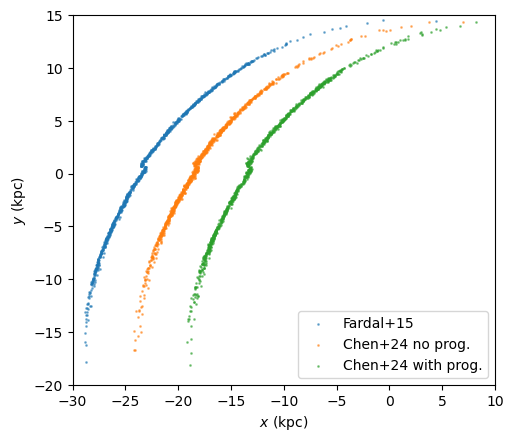

In [7]:
plt.scatter(xv_stream_f15[:,0]-5, xv_stream_f15[:,1], s=1, alpha=0.5, label='Fardal+15')
plt.scatter(xv_stream_c24[:,0], xv_stream_c24[:,1], s=1, alpha=0.5, label='Chen+24 no prog.')
plt.scatter(xv_stream_c24b[:,0]+5, xv_stream_c24b[:,1], s=1, alpha=0.5, label='Chen+24 with prog.')

plt.xlabel(r'$x\ ({\rm kpc})$')
plt.ylabel(r'$y\ ({\rm kpc})$')
plt.xlim(-30, 10)
plt.ylim(-20, 15)
plt.legend()
plt.gca().set_aspect(1)
plt.show()

## Action space distribution

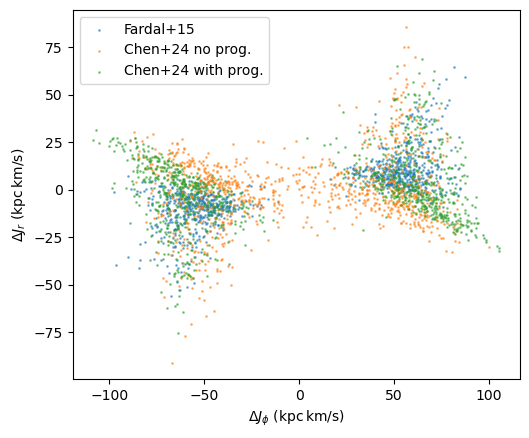

In [8]:
actFinder = agama.ActionFinder(pot)

def get_action(stream, prog, actFinder):
    action_prog = actFinder(prog)
    Jphi_prog = action_prog[2]
    Jr_prog = action_prog[0]
    
    actions = actFinder(stream)
    Jphi = actions[:,2]
    Jr = actions[:,0]
    
    # DLtot = Ltot - Ltot_prog
    DJphi = Jphi - Jphi_prog
    DJr = Jr - Jr_prog
    return DJphi, DJr
    
DJphi, DJr = get_action(xv_stream_f15, orbit_sat_f15[-1], actFinder)
plt.scatter(DJphi, DJr, s=1, alpha=0.5, label='Fardal+15')

DJphi, DJr = get_action(xv_stream_c24, orbit_sat_c24[-1], actFinder)
plt.scatter(DJphi, DJr, s=1, alpha=0.5, label='Chen+24 no prog.')

DJphi, DJr = get_action(xv_stream_c24b, orbit_sat_c24b[-1], actFinder)
plt.scatter(DJphi, DJr, s=1, alpha=0.5, label='Chen+24 with prog.')

plt.xlabel(r'$\Delta J_\phi\ ({\rm kpc\,km/s})$')
plt.ylabel(r'$\Delta J_r\ ({\rm kpc\,km/s})$')
plt.legend()
plt.gca().set_aspect(1)
plt.show()